In [1]:
! pip install -q kaggle

In [2]:
from glob import glob
import numpy as np
import pandas as pd
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
import sklearn
import matplotlib.pyplot as plt
from PIL import Image
import os

#from tqdm import tqdm_notebook,trange
print("done import")

done import


In [3]:
from google.colab import files

files.upload()

dataset = 'histopathologic-cancer-detection'

!rm -r $dataset

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c $dataset

zip_file = f"{dataset}.zip"
destination_dir = f"/content/{dataset}"

if not os.path.exists(zip_file):
    print(f"Error: {zip_file} not found.")
else:
    !unzip -q $zip_file -d $destination_dir
    !rm $zip_file

Saving kaggle.json to kaggle.json
rm: cannot remove 'histopathologic-cancer-detection': No such file or directory
rm: cannot remove '/root/.kaggle': No such file or directory
100% 6.30G/6.31G [00:51<00:00, 191MB/s]
100% 6.31G/6.31G [00:51<00:00, 133MB/s]


In [4]:
path = './histopathologic-cancer-detection/'
train_path = './histopathologic-cancer-detection/train/'
test_path = './histopathologic-cancer-detection/test/'

In [5]:
all_train_df = pd.read_csv(path+"train_labels.csv")
all_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
print("Train Size: {}".format(len(os.listdir(train_path))))
print("Test Size: {}".format(len(os.listdir(test_path))))

Train Size: 220025
Test Size: 57458


In [7]:
label_counts = all_train_df.label.value_counts()
print(label_counts)



label
0    130908
1     89117
Name: count, dtype: int64


In [27]:
# Number of samples in each class
SAMPLE_SIZE = 50000


# Use 80000 positive and negative examples
df_label0 = all_train_df[all_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_label1 = all_train_df[all_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_label0, df_label1], axis=0).reset_index(drop=True))

train_df.shape

(100000, 2)

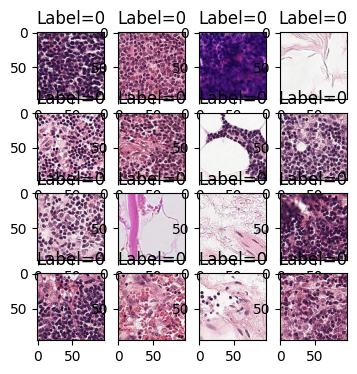

In [28]:
#print(train_df.head(2))
#print(train_imgs[1])
N_plot=4
fig = plt.figure(figsize=(N_plot, N_plot))

for i in range(1,N_plot**2+1):
        img=Image.open(train_path+train_df['id'][i]+'.tif')
        fig.add_subplot(N_plot, N_plot, i)
        plt.imshow(img)
        plt.title('Label=%s'%train_df['label'][i])






In [29]:
# Loading N images from df dataframe
def load_data(N,df):
    X = np.zeros([N,96,96,3],dtype=np.uint8)
    y = np.squeeze(df['label'][0:N])
    for i in range(0,N):
        img=Image.open(train_path+df['id'][i]+'.tif')
        img_rgb = img.convert('RGB')
        X[i] = np.array(img_rgb)
    return X,y

In [30]:
load_fake_data=False

if load_fake_data:
  img=Image.open(train_path+'lines_proto.tiff')
  img_rgb = img.convert('RGB')
  x0 = np.array(img_rgb)

  img=Image.open(train_path+'x_proto.tiff')
  img_rgb = img.convert('RGB')
  x1 = np.array(img_rgb)

  def generate_data(N):
  # Loading N images from df dataframe
      X = np.zeros([N,96,96,3],dtype=np.uint8)
      y = np.zeros([N,1],dtype=np.uint8);
      for i in range(0,N):
          if i%2==0:
              X[i] = x0+np.random.normal(0,2/2,(96,96,3))
              y[i]=np.int32(0)
          else:
              X[i] = x1+np.random.normal(0,60/2,(96,96,3))
              y[i]=np.int32(1)

      return X,y

In [31]:
def convert_binary_to_two_class(y):
    N=len(y);
    y2 = np.zeros([N,2],dtype=np.uint8)
    y2[:,0]=y[:,0];
    y2[:,1]=1-y[:,0]
    return y2




In [32]:

if load_fake_data==False:
    X,y = load_data(N=2*SAMPLE_SIZE,df=train_df)
    y=np.reshape(y,[len(y),1])
    print(X.shape)
    print(y.shape)

(100000, 96, 96, 3)
(100000, 1)


In [33]:
if load_fake_data==True:
    X,y = generate_data(N=2*SAMPLE_SIZE)
    print(X.shape)
    print(y.shape)

In [34]:
#y=convert_binary_to_two_class(y)
print(y.shape)

(100000, 1)


In [35]:
print(y[0:10,:])

[[1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]]


In [36]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

[0]


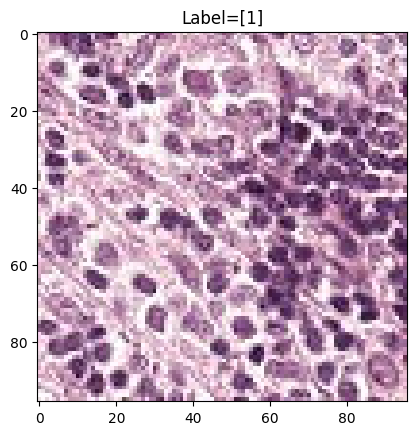

In [37]:
k=14
print(y[k])
plt.imshow(X_train[k], cmap='hot', interpolation='nearest')
plt.title('Label='+str(y_train[k]))
plt.show()

[0]


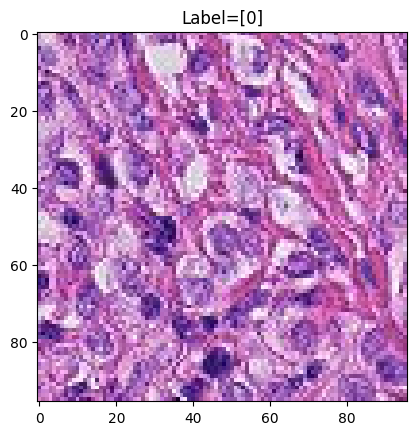

In [38]:
k=18
print(y[k])
plt.imshow(X_train[k], cmap='hot', interpolation='nearest')
plt.title('Label='+str(y_train[k]))
plt.show()

In [39]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(67000, 96, 96, 3)
(67000, 1)
(33000, 96, 96, 3)
(33000, 1)


In [40]:
#create random batches for training

N_train=len(X_train)
batch_size=50;
N_batches=np.int32(np.floor(N_train/batch_size))
def random_batch(n, k, tot):
    start_points = np.sort(np.random.randint(0, tot-k, size=n))
    end_points = start_points + k
    end_points[:-1] = np.maximum(end_points[:-1], start_points[1:])
    return list(zip(np.int32(start_points), np.int32(end_points)))


batches=random_batch(N_batches,batch_size,N_train)
#print(len(batches))
#print(batches)


In [41]:

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(96, 96, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)

x = keras.layers.Conv2D(128, (3,3), activation='relu')(x)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

#x = keras.layers.Dense(1024)(x)
x = keras.layers.Dense(512)(x)
x = keras.layers.Dense(256)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         Y          
                                                                            
 xception (Functional)       (None, 3, 3, 2048)        2086148   N          
                                                       0                    
                                                                            
 conv2d_9 (Conv2D)           (None, 1, 1, 128)         2359424   Y          
                                                                            
 global_average_pooling2d_1  (None, 128)               0         Y          
  (GlobalAveragePooling2D)                                 

In [42]:
#model.summary()

In [43]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])


In [ ]:
N_epochs=12;


for epoch in range(1,N_epochs+1):
    model.fit(X_train,y_train, validation_data=(X_val,y_val))

  23/2094 [..............................] - ETA: 1:07 - loss: 7.3138 - accuracy: 0.5204